In [1]:
!pip install kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [3]:
! mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download -d ismailpromus/skin-diseases-image-dataset


100% 5.17G/5.19G [01:23<00:00, 121MB/s]
100% 5.19G/5.19G [01:23<00:00, 66.6MB/s]


In [14]:
!mkdir /content/drive/MyDrive/Skin_Disease_Data

In [15]:
!mv /content/skin-diseases-image-dataset.zip /content/drive/MyDrive/Skin_Disease_Data

## Importing Libraries

In [35]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Unzipping Data

In [17]:
!unzip /content/drive/MyDrive/Skin_Disease_Data/skin-diseases-image-dataset.zip -d /content/drive/MyDrive/Skin_Disease_Data/Skin_Data

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-65.jpg  
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-66.jpg  
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-67.jpg  
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-69.jpg  
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictures Lichen Planus and related diseases - 2k/t-Lichen-Sclerosus-Skin-7.jpg  
  inflating: /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/7. Psoriasis pictur

In [19]:
img_path = os.path.join("/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/1. Eczema 1677",os.listdir('/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/1. Eczema 1677')[0])
img_path

'/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES/1. Eczema 1677/0_0.jpg'

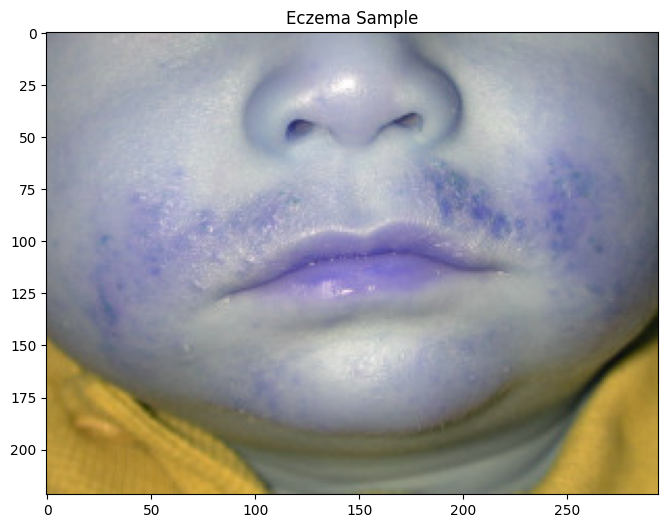

In [21]:
img = cv2.imread(img_path)
plt.figure(figsize=(10,6))

plt.imshow(img)
plt.title("Eczema Sample")

plt.show()


In [23]:
## Explore The Shape Of Data Sample Images
img.shape

(222, 294, 3)

## Splitting Data Into 80% Train || 20 % Test

In [24]:
!pip install split_folders

In [27]:
import splitfolders

In [30]:
os.makedirs('output')
os.makedirs('train')
os.makedirs('test')

loc = "/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/IMG_CLASSES"

splitfolders.ratio(loc,output ="output",ratio = (0.8,.2))

Copying files: 27153 files [11:34, 39.10 files/s] 


In [34]:
!mv /content/output /content/drive/MyDrive/Skin_Disease_Data/Skin_Data/Out

## Preparing Train and Test Dirs

In [36]:
train_dir = r'/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/Out/train'
test_dir = r'/content/drive/MyDrive/Skin_Disease_Data/Skin_Data/Out/val'

## Setup Early Stopping technique & ReduceLr Technique

In [38]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

## Setup The Model By Using VGG16 CNN Backbone Structure

In [39]:
# Load pre-trained VGG model without top layers (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [40]:
# Freeze the layers in the VGG model
for layer in vgg_model.layers:
    layer.trainable = False

In [41]:
# Customizing the VGG model with additional layers for skin disease classification
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Adjust num_classes as per your dataset

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Initialize Augumentation For Train || Test

In [42]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test sets


## Loading Train & Test Data With Augumentation Applied

In [37]:
# train_data = image_dataset_from_directory(train_dir,label_mode = "categorical",
#                                           image_size = (224,224),batch_size = 32,
#                                          shuffle = True,seed = 42)
# test_data = image_dataset_from_directory(test_dir,label_mode = "categorical",
#                                           image_size = (224,224),batch_size = 32,
#                                          shuffle = False,seed = 42)

Found 21719 files belonging to 10 classes.
Found 5434 files belonging to 10 classes.


In [43]:
# Provide the path to your dataset
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 21719 images belonging to 10 classes.
Found 5434 images belonging to 10 classes.


In [54]:
classes_dict = train_generator.class_indices
classes_dict

{'1. Eczema 1677': 0,
 '10. Warts Molluscum and other Viral Infections - 2103': 1,
 '2. Melanoma 15.75k': 2,
 '3. Atopic Dermatitis - 1.25k': 3,
 '4. Basal Cell Carcinoma (BCC) 3323': 4,
 '5. Melanocytic Nevi (NV) - 7970': 5,
 '6. Benign Keratosis-like Lesions (BKL) 2624': 6,
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 7,
 '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 8,
 '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 9}

## Classes Mapping

## Model Summary

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21140042 (80.64 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Training Model

In [ ]:
# Train the model
model.fit(
        train_generator,
        epochs=50,
)

Epoch 1/50


In [ ]:
def predictor(sdir, csv_path,  model_path, crop_image = False):
    # read in the csv file
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
        if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count